# Exploratory Data Analysis

In this notebook, we will explore the air quality data of the city of Rio de Janeiro. From these results, we can gain insights into the machine learning algorithm. We divide the analysis as follows: 

1. Understading the data: what the data looks like, what are the information we have and what we can use;
2. Data exploration: visualizing the data and looking for some patterns; e
3. Data cleaning and feature engeneering.

## Understanding the data 

Load the necessary libraries and the data. 

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

## Definitions for the notebook

In [2]:
IMAGES_FOLDER = "../notes/images/"

sns.set()

%matplotlib inline

## Structure of the dataset

In [3]:
air_data = pd.read_csv("../data/RiodeJaneiro_MonitorAr_hourly.csv")
air_data.head()

,Data,CodNum,Estação,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,...,NO,NOx,O3,PM10,PM2_5,Lat,Lon,X_UTM_Sirgas2000,Y_UTM_Sirgas2000,OBJECTID
0,2012/01/01 00:30:00+00,2,BG,0.2,1008.15,NaN,24.67,95.24,NaN,NaN,...,2.18,17.36,28.06,81.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,1
1,2012/01/01 01:30:00+00,2,BG,0.4,1007.13,NaN,24.72,94.13,NaN,NaN,...,1.63,11.12,32.81,61.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,2
2,2012/01/01 02:30:00+00,2,BG,0.0,1006.32,NaN,24.49,92.91,NaN,NaN,...,1.73,10.47,31.61,26.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,3
3,2012/01/01 03:30:00+00,2,BG,0.2,1005.82,NaN,24.54,92.59,NaN,NaN,...,1.18,6.68,37.39,20.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,4
4,2012/01/01 04:30:00+00,2,BG,0.4,1005.45,NaN,24.78,90.71,NaN,NaN,...,0.95,9.35,33.45,7.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,5


### Monitored parameters

* `Data`: Date of the observation. 
* `CodNun`: Station code. 
* `Estação`: One of the monitoring stations given below. 
* `Chuva`: Rainfall (mm).
* `Pres`: Atmospheric Pressure (mbar).
* `RS` : Solar radiation (w/m2).
* `Temp`: Temperature (° C).
* `UR`: Relative humidity (%).
* `Dir_Vento`: Wind direction (°)
* `Vel_Vento`: Wind speed (m/s)
* `Lat`: Latitude position of the station 
* `Lon`: Longitude position of the station 
* `X_UTM_Sirgas2000`: Latitude in the Sirgas 2000 referential
* `Y_UTM_Sirgas2000`: Longitude in the Sirgas 2000 referential
* `OBJECTID`: Enumeration

### Stations and monitored gases
---

- Centro (CA): O3, CO, PM10
- Copacabana (AV): SO2, O3, CO, PM10
- São Cristóvão (SC): SO2,  O3, CO, PM10
- Tijuca (SP): SO2, NOx, O3, CO, PM10
- Irajá (IR): SO2, NOx, O3, CO, HC, PM2.5, PM10
- Bangu (BG): SO2, NOx, O3, CO, HC, PM10
- Campo Grande (CG): SO2, NOx, O3, CO, HC, PM10
- Pedra de Guaratiba (PG): O3, PM10

CO and HC are measured in (ppm), while the others are measured in (µg/m3).

In [4]:
air_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661662 entries, 0 to 661661
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Data              661662 non-null  object 
 1   CodNum            661662 non-null  int64  
 2   Estação           661662 non-null  object 
 3   Chuva             645850 non-null  float64
 4   Pres              646368 non-null  float64
 5   RS                613402 non-null  float64
 6   Temp              591045 non-null  float64
 7   UR                551043 non-null  float64
 8   Dir_Vento         571164 non-null  float64
 9   Vel_Vento         570919 non-null  float64
 10  SO2               464874 non-null  float64
 11  NO2               271157 non-null  float64
 12  HCNM              200083 non-null  float64
 13  HCT               199993 non-null  float64
 14  CH4               200140 non-null  float64
 15  CO                547483 non-null  float64
 16  NO                27

From these informations we can already see that some features are redundants. For instance, OBJECTID is the same as id, so we can remove it. The same with the colums CodNum and Estação, Lat/Lon and X/Y_UTM_Sirgas_2000. We will keep track of the relation in a dictionary and only keep the CodNum information and Lat/Lon. This will save around 20mb of information. We see that the gases have a lot of null values, because they are measured differently at each station, so we will keep them all. 

In [5]:
stations = air_data[['CodNum', 'Estação', 'X_UTM_Sirgas2000', 'Y_UTM_Sirgas2000']].drop_duplicates()
stations_info = zip(stations.Estação, stations.X_UTM_Sirgas2000, stations.Y_UTM_Sirgas2000)
stations = dict(zip(stations.CodNum, stations_info))

air_data.drop(labels = ['OBJECTID', 'Estação', 'X_UTM_Sirgas2000', 'Y_UTM_Sirgas2000'], axis = 1, inplace = True)

Convert the date to `datetime` dtype.

In [86]:
air_data.Data = pd.to_datetime(air_data.Data) 

air_data["year"] = air_data.Data.apply(lambda x: x.year)
air_data["month"] = air_data.Data.apply(lambda x: x.month)
air_data["day"] = air_data.Data.apply(lambda x: x.day)
air_data["hour"] = air_data.Data.apply(lambda x: x.hour)

## Missing and zero values

First, we see the missing values in the whole dataset

In [87]:
missing_values_df = air_data.isna().sum()
missing_values_prop_df = missing_values_df/air_data.shape[0]
for line, num in enumerate(missing_values_df):
    missing_values_df.iloc[line] = str(num) + " (" + str(100*missing_values_prop_df.iloc[line])[:4] + " %)"
missing_values_prop_df

Data         0.000000
CodNum       0.000000
Chuva        0.023897
Pres         0.023115
RS           0.072938
Temp         0.106727
UR           0.167184
Dir_Vento    0.136774
Vel_Vento    0.137144
SO2          0.297415
NO2          0.590188
HCNM         0.697605
HCT          0.697741
CH4          0.697519
CO           0.172564
NO           0.590165
NOx          0.590227
O3           0.056121
PM10         0.054623
PM2_5        0.892058
Lat          0.000000
Lon          0.000000
year         0.000000
month        0.000000
day          0.000000
hour         0.000000
dtype: float64

Observe that CO is not measured in Pedra de Guaratiba. If we desconsider it, the proportion falls for 6\%. 

In [88]:
(air_data[air_data.CodNum != 6].isna().sum()/air_data[air_data.CodNum != 6].shape[0]).loc['CO']

0.06281475851538401

The proportion of zero values is the following

In [89]:
zero_values_df = air_data.eq(0).sum()
zero_values_df/air_data.shape[0]

Data         0.000000
CodNum       0.000000
Chuva        0.909718
Pres         0.000000
RS           0.260743
Temp         0.000128
UR           0.000635
Dir_Vento    0.001786
Vel_Vento    0.006358
SO2          0.061114
NO2          0.000060
HCNM         0.007313
HCT          0.000000
CH4          0.000000
CO           0.015349
NO           0.000017
NOx          0.000017
O3           0.009679
PM10         0.001953
PM2_5        0.002832
Lat          0.000000
Lon          0.000000
year         0.000000
month        0.000000
day          0.000000
hour         0.041669
dtype: float64

In [167]:
consider_var = ['Chuva', 'Pres', 'RS', 'Temp', 'UR', 'Dir_Vento', 'Vel_Vento', 'CO', 'O3', 'PM10']
miss_per_year = air_data.groupby("year").agg(lambda x: pd.isna(x).sum()/len(x))[consider_var]
miss_per_code = air_data.groupby("CodNum").agg(lambda x: pd.isna(x).sum()/len(x))[consider_var]

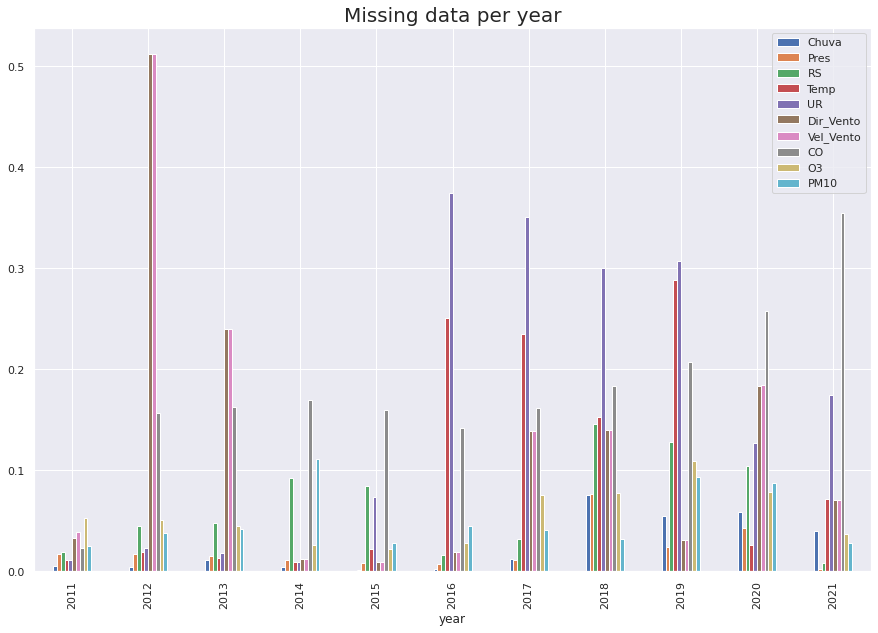

In [176]:
miss_per_year.plot.bar(figsize = (15,10))
plt.title('Missing data per yea', fontsize = 20)
plt.show()

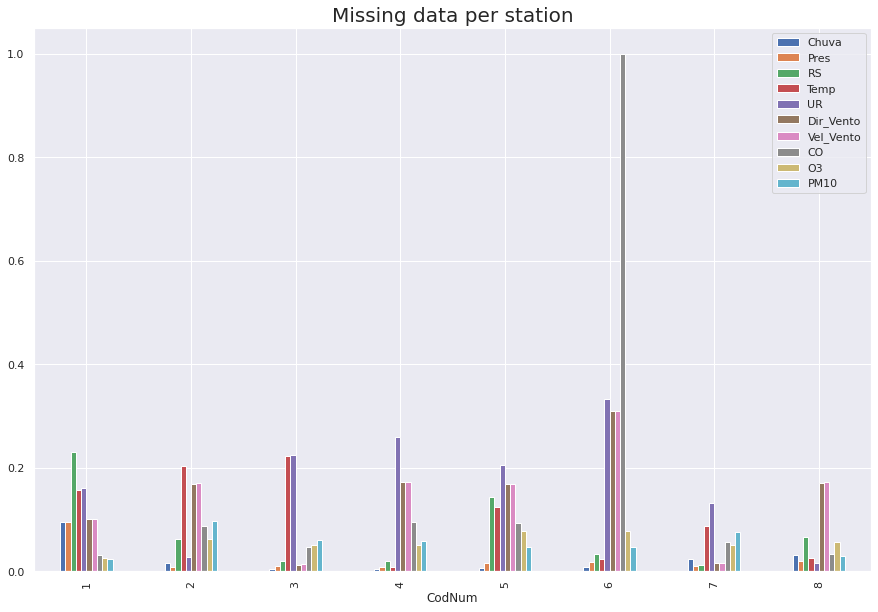

In [177]:
miss_per_code.plot.bar(figsize = (15,10))
plt.title('Missing data per station', fontsize = 20)
plt.show()

In [213]:
air_data.groupby(["year", "month", "day", "hour"])[consider_var].sum().isna().sum()

Chuva        0
Pres         0
RS           0
Temp         0
UR           0
Dir_Vento    0
Vel_Vento    0
CO           0
O3           0
PM10         0
dtype: int64